# Data visualization
Don't trust summary statistics. Visualize your data.

<img src="../../misc/DinoSequentialSmaller.gif">

[The Datasaurus Dozen](https://www.autodeskresearch.com/publications/samestats)

In [163]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from os.path import join
import sys

cwd = os.getcwd()
data_path = join(cwd, '..', '..', 'data')

sns.set(style='white', palette='tab10',
        context='notebook', font_scale=1.25,
        rc={'axes.linewidth': 1.5,
            'axes.grid': True,
            'axes.spines.right': False,
            'axes.spines.top': False})

In [164]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = join(os.getcwd(), '..', '..', 'src')
sys.path.append(src_dir)

In [165]:
# Import function to filter very large outliers
%aimport data.filter_outliers
from data.filter_outliers import filter_outliers

## Load data

In [115]:
path = join(data_path, 'processed', 'facility_gen_emissions.csv')
df = pd.read_csv(path)

In [116]:
df.head()

,plant_id,month,nerc_region,net_gen_mwh,primary_fuel,fuel_category,state,facility_name,year,gross_load_mwh,heat_input_mmbtu,so2_kg,nox_kg,co2_kg
0,2,1,SERC,-77.112,HYC,Hydro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,SERC,-69.679,HYC,Hydro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,3,SERC,-48.374,HYC,Hydro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,4,SERC,-24.341,HYC,Hydro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,5,SERC,-11.476,HYC,Hydro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
df.describe()

,plant_id,month,net_gen_mwh,year,gross_load_mwh,heat_input_mmbtu,so2_kg,nox_kg,co2_kg
count,96804.000000,96804.00000,9.680400e+04,14268.0,1.217300e+04,1.263300e+04,1.237600e+04,1.261100e+04,1.193300e+04
mean,37809.592290,6.50000,4.208891e+04,2016.0,1.978950e+05,1.748935e+06,1.076048e+05,8.361645e+04,1.442506e+08
std,25574.435523,3.45207,1.616259e+05,0.0,2.931747e+05,2.656279e+06,3.362412e+05,1.956038e+05,2.436715e+08
min,2.000000,1.00000,-1.166600e+05,2016.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6403.000000,3.75000,1.618765e+02,2016.0,4.473720e+03,5.157650e+04,2.630836e+01,1.422012e+03,4.154263e+06
50%,55294.000000,6.50000,1.123354e+03,2016.0,5.714276e+04,5.522278e+05,3.256793e+02,8.697180e+03,4.162735e+07
75%,58204.000000,9.25000,1.130649e+04,2016.0,2.895860e+05,2.460346e+06,1.685753e+04,5.133305e+04,1.637654e+08
max,61416.000000,12.00000,3.007729e+06,2016.0,2.093063e+06,2.232883e+07,4.685651e+06,2.172677e+06,2.124489e+09


In [118]:
len(df['state'].dropna()), len(df['facility_name'].dropna()), len(df['year'].dropna())

(14268, 14268, 14268)

In [119]:
df.fuel_category.unique()

array(['Hydro', 'Natural Gas', 'Coal', 'Nuclear', 'Petroleum', 'Other',
       'Wind', 'Solar'], dtype=object)

## Create a second dataframe with only records that have both *net_gen_mwh* and EPA emissions data
This is what we would have gotten with an inner join. From the information above it looks like there rows mission only some of the EPA values. It seems like a safe assumption that every EPA record has a value for `year`.

EIA net generation values can be negative. I'm going to use this data to calculate emission rates and don't want to deal with negative values for now so I'll only include records with positive (and non-zero) net generation. This will make plotting easier and isn't necessarily the best way to deal with this data for the purpose of analysis.

In [120]:
# I'm doing a copy of the returned dataframe object here because
# Pandas was giving a SettingWithCopyWarning later on.
df2 = df.dropna(subset=['year']).copy()

In [121]:
len(df2)

14268

In [122]:
df2.fuel_category.unique()

array(['Natural Gas', 'Coal', 'Wind', 'Other', 'Petroleum', 'Hydro',
       'Nuclear', 'Solar'], dtype=object)

In [123]:
df2 = df2.loc[df2['net_gen_mwh'] > 0]
len(df2)

12724

## Matplotlib
[Matplotlib](https://matplotlib.org/) is probably the most popular Python plotting package and it improved significantly with version 2.0. If you can imagine a figure, and have several hours/days of spare time, you can probably make it with matplotlib. On the plus side it allows you to customize nearly every pixel on a figure.

Text(0,0.5,'Total generation (MWh)')

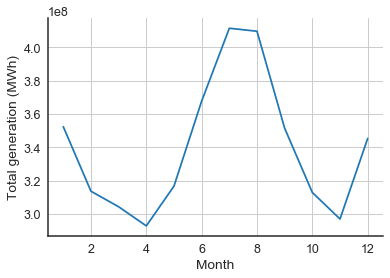

In [108]:
# group to generation by month
total_monthly = df.groupby('month', as_index=False).sum()

plt.plot(total_monthly.month, total_monthly.net_gen_mwh)
plt.xlabel('Month')
plt.ylabel('Total generation (MWh)')

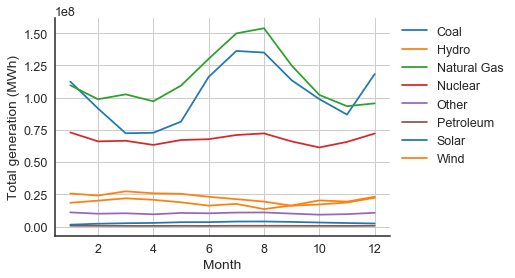

In [124]:
# group to generation by month and fuel
total_monthly_fuel = df.groupby(['month', 'fuel_category'], as_index=False).sum()

for fuel in total_monthly_fuel.fuel_category.unique():
    # Set x and y values
    x = total_monthly_fuel.loc[total_monthly_fuel['fuel_category'] == fuel, 'month']
    y = total_monthly_fuel.loc[total_monthly_fuel['fuel_category'] == fuel, 'net_gen_mwh']
    plt.plot(x, y, label=fuel)
    
plt.xlabel('Month')
plt.ylabel('Total generation (MWh)')
plt.legend(loc=(1.02 , 0.3))

### Plot with Pandas
Pandas has several matplotlib wrapper methods that let you plot the data in a dataframe. It will use the information (e.g. column names) to provide some labels on the figure.

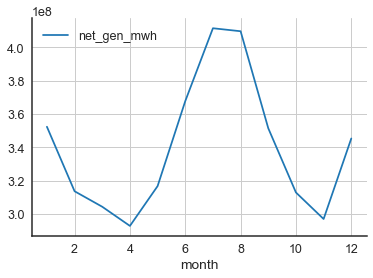

In [125]:
total_monthly.plot(x='month', y='net_gen_mwh')

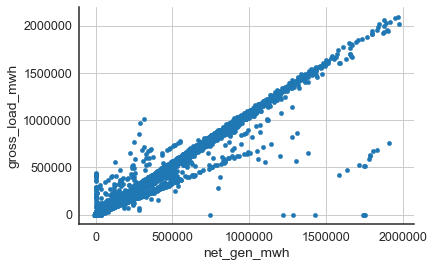

In [126]:
df.plot.scatter('net_gen_mwh', 'gross_load_mwh')

## Plot with Seaborn
Seaborn also wraps functions around matplotlib and provides much more powerful tools for exploring data. It was designed to work closely with Pandas dataframes. I highly recommend going through the [Seaborn tutorial](https://seaborn.pydata.org/tutorial.html). 

### Distributions

/Users/Home/anaconda/envs/pydata-issst/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


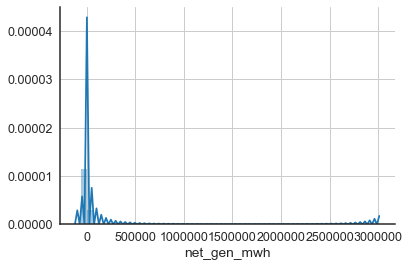

In [127]:
sns.distplot(df.net_gen_mwh)

/Users/Home/anaconda/envs/pydata-issst/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


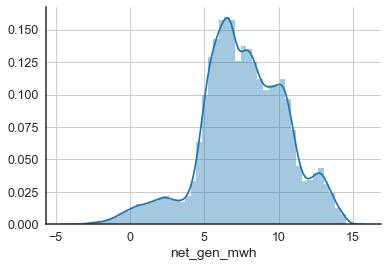

In [128]:
sns.distplot(df.loc[df['net_gen_mwh'] > 0, 'net_gen_mwh'].apply(np.log))

/Users/Home/anaconda/envs/pydata-issst/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Home/anaconda/envs/pydata-issst/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


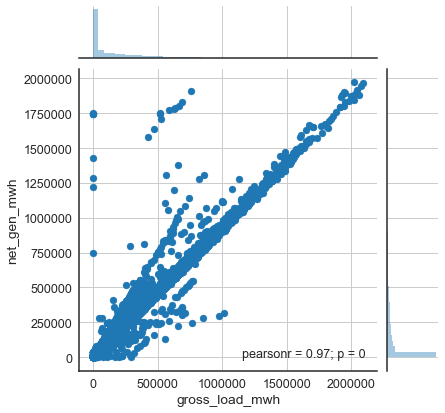

In [129]:
sns.jointplot(x='gross_load_mwh', y='net_gen_mwh', data=df2)

/Users/Home/anaconda/envs/pydata-issst/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Home/anaconda/envs/pydata-issst/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


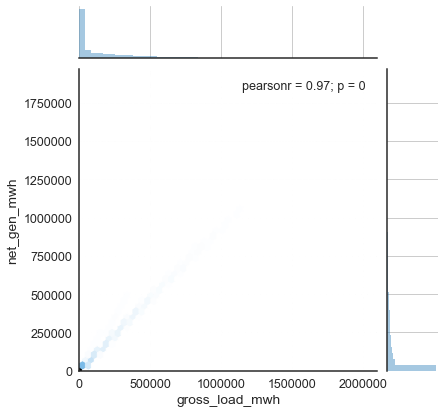

In [130]:
sns.jointplot(x='gross_load_mwh', y='net_gen_mwh', data=df2, kind='hex')

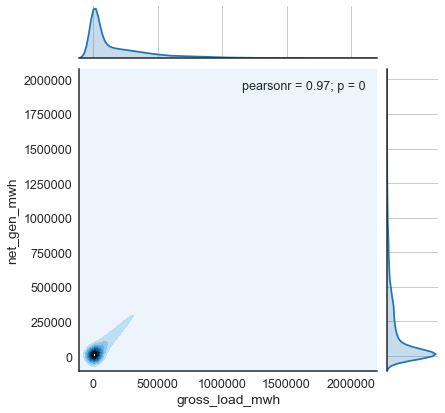

In [131]:
sns.jointplot(x='gross_load_mwh', y='net_gen_mwh', data=df2, kind='kde')

/Users/Home/anaconda/envs/pydata-issst/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Home/anaconda/envs/pydata-issst/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


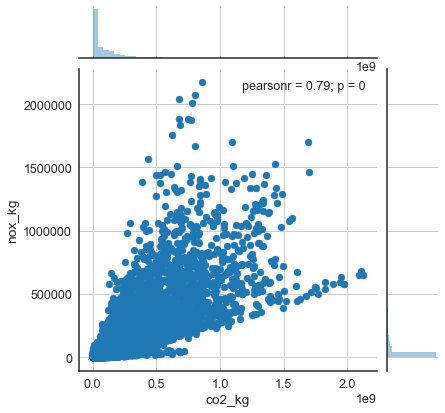

In [132]:
sns.jointplot(x='co2_kg', y='nox_kg', data=df2)

### Categorical

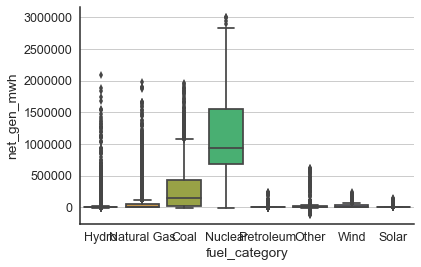

In [133]:
sns.boxplot(x='fuel_category', y='net_gen_mwh', data=df)

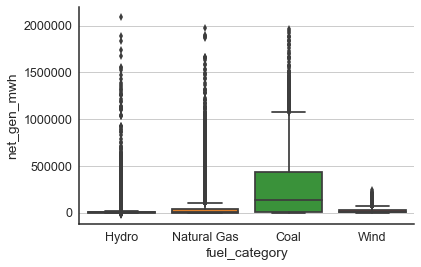

In [134]:
fuels = ['Coal', 'Natural Gas', 'Hydro', 'Wind']
data = df.loc[df['fuel_category'].isin(fuels)]

sns.boxplot(x='fuel_category', y='net_gen_mwh', data=data)

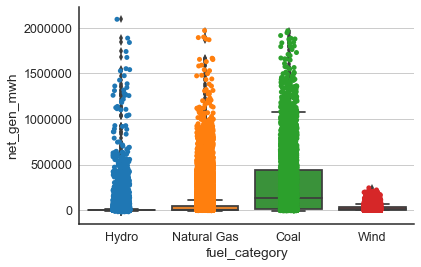

In [135]:
fuels = ['Coal', 'Natural Gas', 'Hydro', 'Wind']
data = df.loc[df['fuel_category'].isin(fuels)]

sns.boxplot(x='fuel_category', y='net_gen_mwh', data=data)
sns.stripplot(x='fuel_category', y='net_gen_mwh', data=data, jitter=True)

Now I'll use the month as an **ordinal** variable on the x axis.

First I want to calculate the monthly emissions rate for each facility and emissions type.

$$rate = \frac{mass}{generation}$$

In [136]:
for col in ['nox_kg', 'so2_kg', 'co2_kg']:
    rate_col = col.replace('kg', 'rate')
    df2[rate_col] = df2[col] / df2['net_gen_mwh']
    df2[rate_col].replace(np.inf, 0, inplace=True)

In [167]:
# There are some extreme emission rate values. Might want to filter these.
df2.describe([.25, .5, .75, 0.95])

,plant_id,month,net_gen_mwh,year,gross_load_mwh,heat_input_mmbtu,so2_kg,nox_kg,co2_kg,nox_rate,so2_rate,co2_rate
count,12724.000000,12724.000000,1.272400e+04,12724.0,1.178200e+04,1.222900e+04,1.198200e+04,1.220700e+04,1.163800e+04,12207.000000,11982.000000,1.163800e+04
mean,23221.183983,6.551006,1.866477e+05,2016.0,2.038270e+05,1.801964e+06,1.111258e+05,8.630678e+04,1.476375e+08,6.565314,0.598456,3.256373e+03
std,25059.911377,3.396184,2.810751e+05,0.0,2.958103e+05,2.681451e+06,3.411540e+05,1.982405e+05,2.457330e+08,183.057972,4.140040,1.326915e+05
min,3.000000,1.000000,2.590000e-01,2016.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
25%,2451.000000,4.000000,4.333605e+03,2016.0,5.746180e+03,6.550616e+04,2.993710e+01,1.717301e+03,4.924704e+06,0.064146,0.002084,4.114311e+02
50%,7307.000000,7.000000,4.905366e+04,2016.0,6.440407e+04,6.166773e+05,3.533484e+02,9.375754e+03,4.466527e+07,0.313942,0.003439,6.360431e+02
75%,55276.000000,9.000000,2.785188e+05,2016.0,2.994753e+05,2.527780e+06,2.220198e+04,5.572246e+04,1.686989e+08,0.821288,0.314448,9.986448e+02
95%,56604.000000,12.000000,7.855704e+05,2016.0,8.315378e+05,7.587140e+06,6.917982e+05,5.010722e+05,6.952515e+08,3.226546,2.654051,1.492341e+03
max,59926.000000,12.000000,1.970703e+06,2016.0,2.093063e+06,2.232883e+07,4.685651e+06,2.172677e+06,2.124489e+09,10859.948878,251.114646,1.386483e+07


In [168]:
df2 = filter_outliers(df2, columns=['co2_rate', 'so2_rate', 'nox_rate'], percentile=0.95)

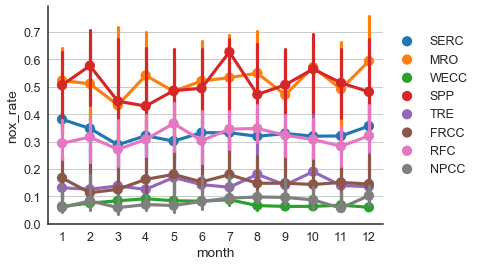

In [169]:
sns.pointplot(x='month', y='nox_rate', hue='nerc_region', data=df2,
              estimator=np.median, palette='tab10')
plt.legend(loc=(1.02, 0.2))

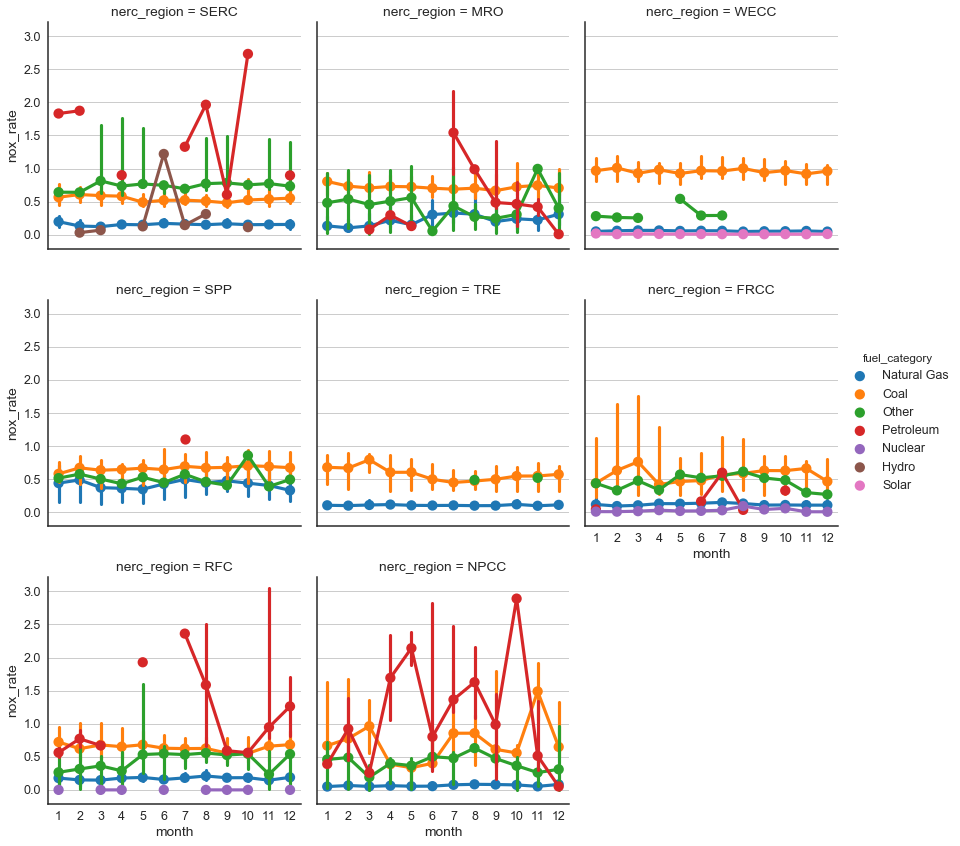

In [173]:
sns.factorplot(x='month', y='nox_rate', hue='fuel_category', col='nerc_region', col_wrap=3,
               data=df2, estimator=np.median, palette='tab10')

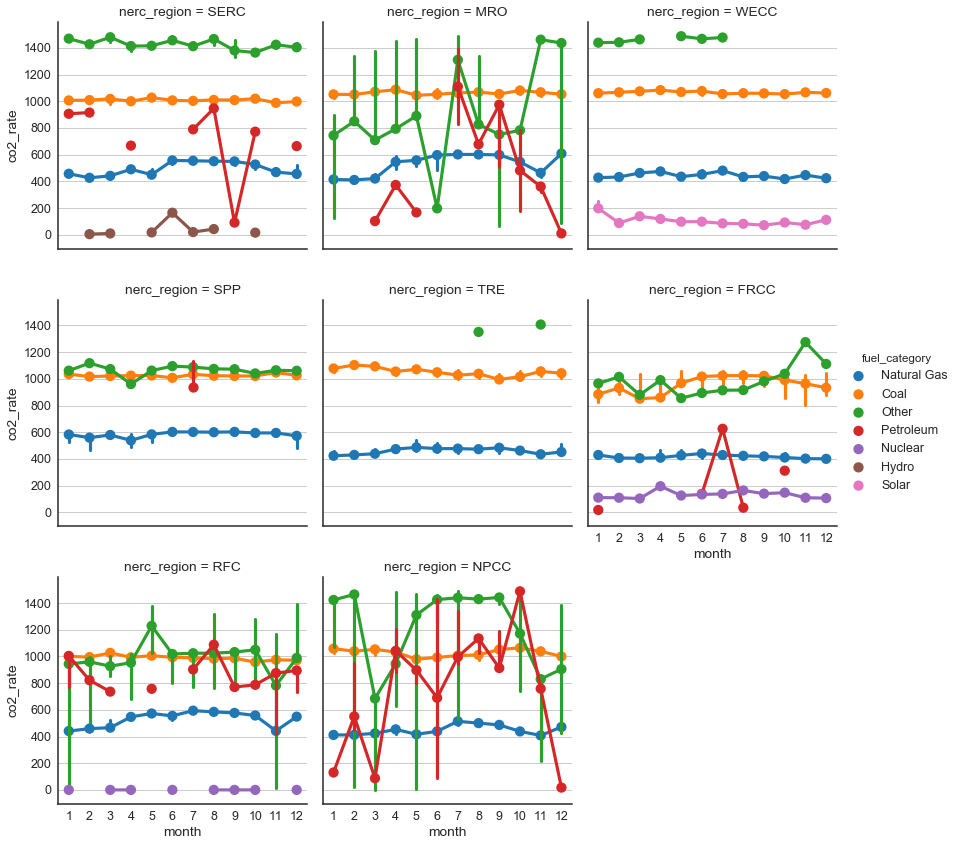

In [172]:
sns.factorplot(x='month', y='co2_rate', hue='fuel_category', col='nerc_region', col_wrap=3,
               data=df2, estimator=np.median, palette='tab10', ci=50)

#### FacetGrid
FacetGrid is a lower-level but incredibly powerful plotting tool. It lets you create a grid with parameters splitting data by row, month, and hue. Then you can plot any function on that grid.

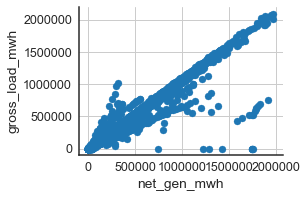

In [174]:
g = sns.FacetGrid(data=df2, aspect=1.5)
g.map(plt.scatter, 'net_gen_mwh', 'gross_load_mwh')

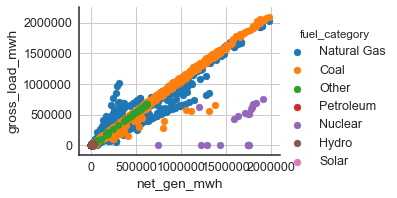

In [175]:
g = sns.FacetGrid(data=df2, hue='fuel_category', aspect=1.5, palette='tab10')
g.map(plt.scatter, 'net_gen_mwh', 'gross_load_mwh')
g.add_legend()

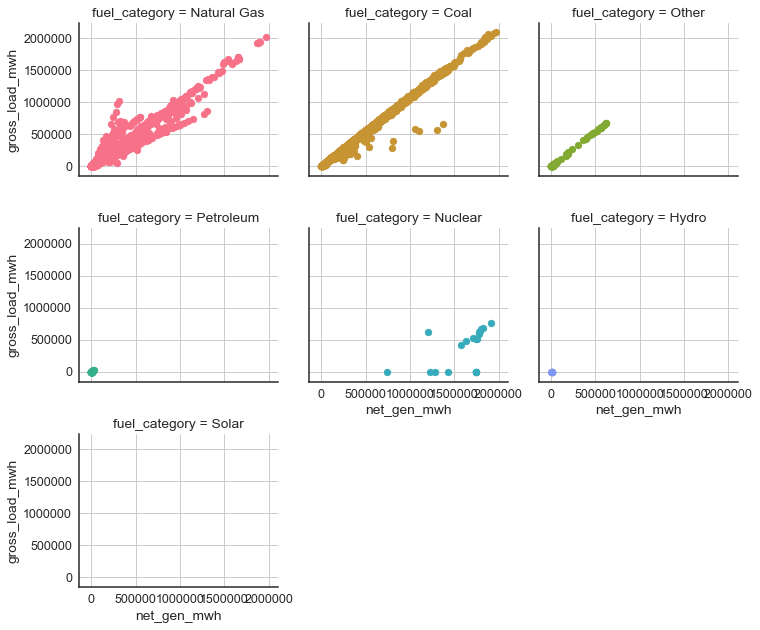

In [210]:
g = sns.FacetGrid(data=df2, hue='fuel_category', col='fuel_category',
                  col_wrap=3, aspect=1.2)
g.map(plt.scatter, 'net_gen_mwh', 'gross_load_mwh')

What's the difference when we change hue to `month` rather than `fuel_category`?

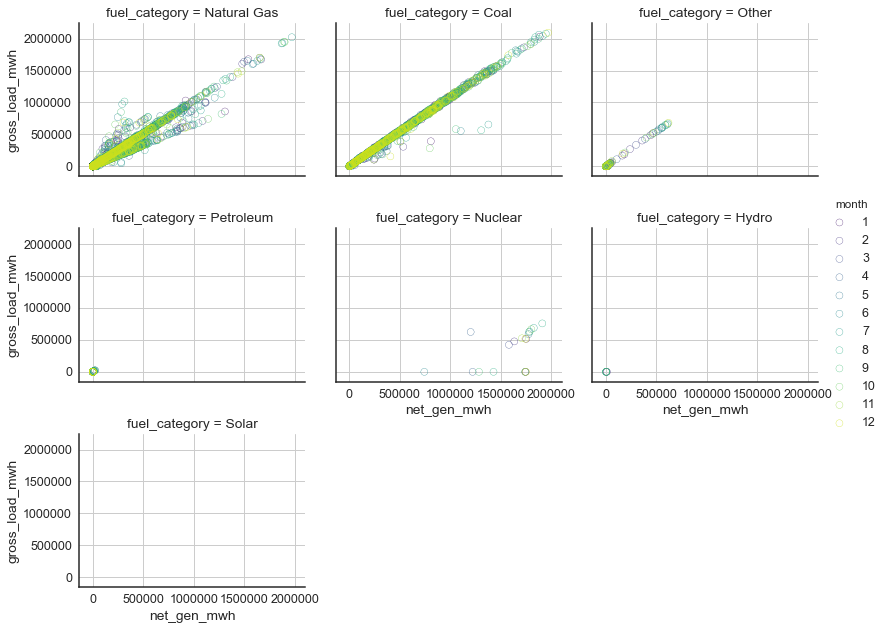

In [211]:
g = sns.FacetGrid(data=df2, hue='month', col='fuel_category',
                  col_wrap=3, aspect=1.3, palette='viridis')
g.map(plt.scatter, 'net_gen_mwh', 'gross_load_mwh', facecolors='none')
g.add_legend()

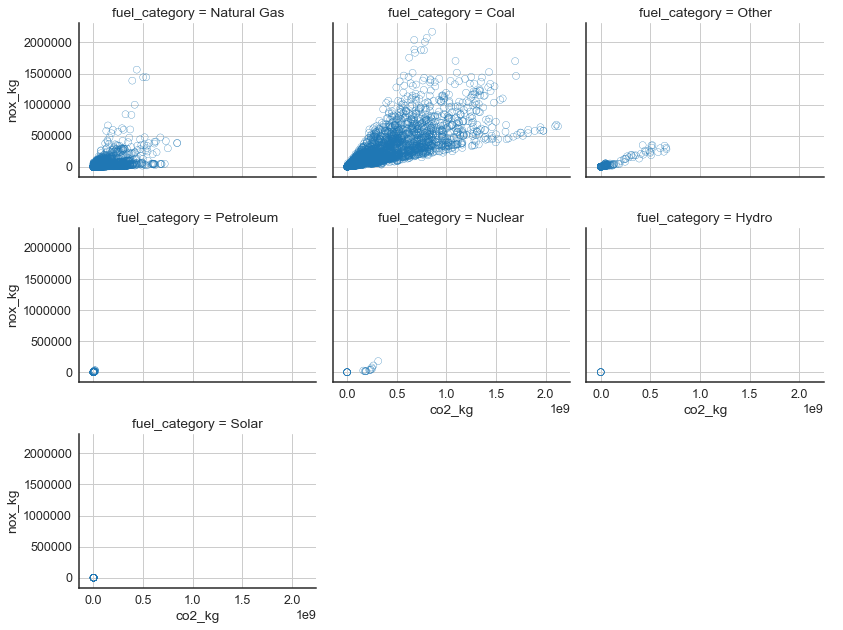

In [212]:
g = sns.FacetGrid(data=df2, col='fuel_category', col_wrap=3, aspect=1.3)
g.map(plt.scatter, 'co2_kg', 'nox_kg', facecolors='none')
g.add_legend()

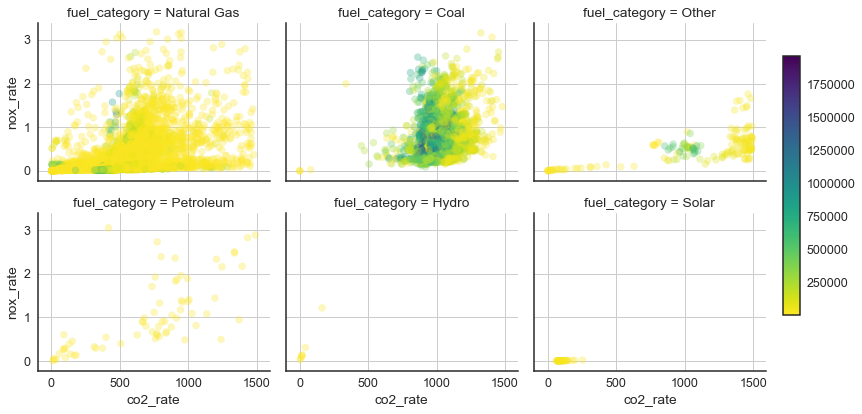

In [207]:
# This code is based on a stackoverflow example
# https://stackoverflow.com/questions/44641669/

def facet_scatter(x, y, c, **kwargs):
    kwargs.pop("color")
    plt.scatter(x, y, c=c, **kwargs)

data = df2.loc[df2.fuel_category != 'Nuclear']
g = sns.FacetGrid(data=data, col='fuel_category', col_wrap=3, aspect=1.3)

vmin, vmax = data.net_gen_mwh.min(), data.net_gen_mwh.max()
cmap = plt.cm.viridis_r
norm=plt.Normalize(vmin=vmin, vmax=vmax)


g.map(facet_scatter, 'co2_rate', 'nox_rate', 'net_gen_mwh', norm=norm, cmap=cmap, alpha=0.3)

# Make space for the colorbar
g.fig.subplots_adjust(right=.92)

# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax, cmap=cmap)

# Draw the colorbar
g.fig.colorbar(points, cax=cax)

## Regressions

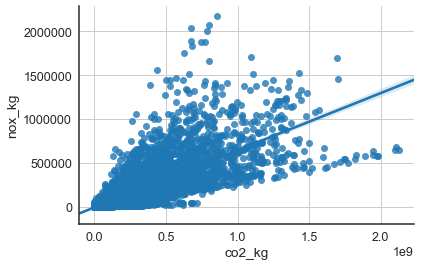

In [148]:
sns.regplot('co2_kg', 'nox_kg', data=df2)

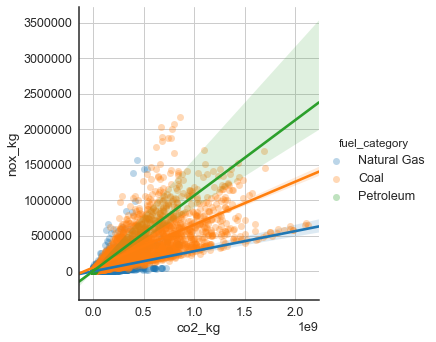

In [158]:
fuels = ['Coal', 'Natural Gas', 'Petroleum']
data = df2.loc[df2['fuel_category'].isin(fuels)]

sns.lmplot('co2_kg', 'nox_kg', data=data,
           hue='fuel_category', scatter_kws={'alpha': '0.3'})

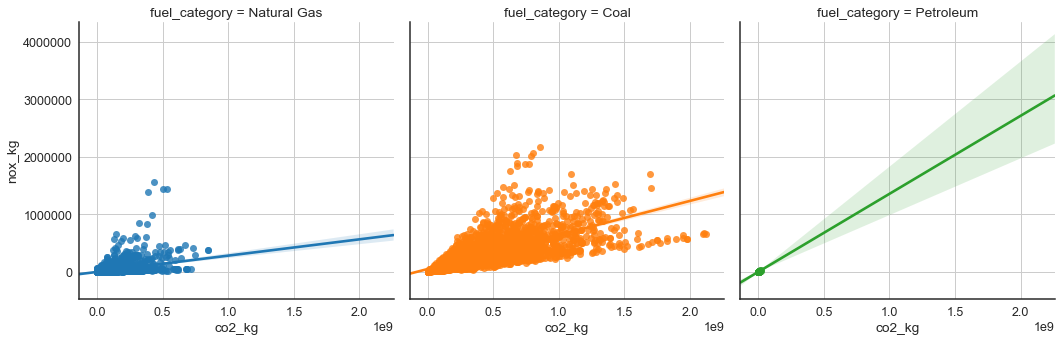

In [209]:
fuels = ['Coal', 'Natural Gas', 'Petroleum']
data = df2.loc[df2['fuel_category'].isin(fuels)]

sns.lmplot('co2_kg', 'nox_kg', data=data, col='fuel_category',
           hue='fuel_category')

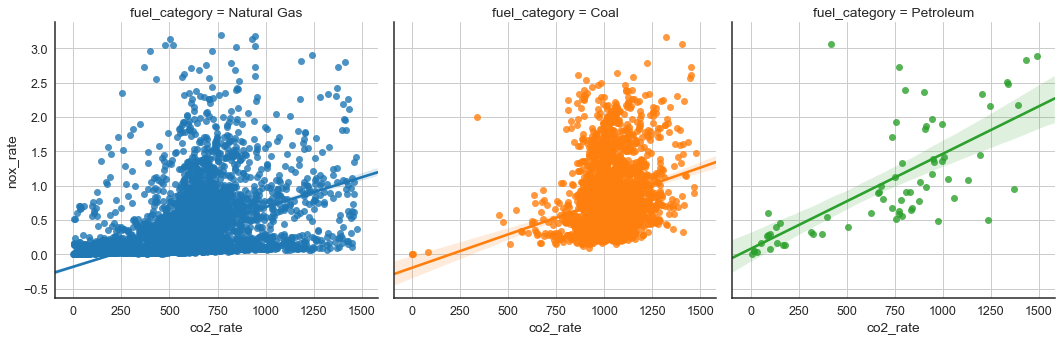

In [208]:
fuels = ['Coal', 'Natural Gas', 'Petroleum']
data = df2.loc[df2['fuel_category'].isin(fuels)]

sns.lmplot('co2_rate', 'nox_rate', data=data, col='fuel_category',
           hue='fuel_category')

In [ ]:
df2.loc[]